#**Step 1: installazione delle librerie**

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q trl xformers wandb datasets einops sentencepiece

In [ ]:
!pip install -q accelerate
!pip install peft
!pip install bitsandbytes
!pip install transformers
!pip install trl
!pip install huggingface_hub
!pip install accelerate
!pip install --upgrade torch

#**Step 2: caricamento delle librerie**

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer

#import wandb, platform, warnings
import warnings

import pandas as pd
from datasets import Dataset
import re
import random

Dataset per addestrare Mistral:

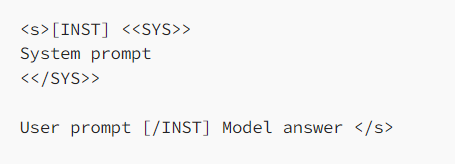

#**Step 3: impostazione delle variabili**

In [ ]:
percentuale_dataset = 0.2

# The model that you want to train from the Hugging Face hub
model_name = "mistralai/Mistral-7B-v0.1"

# Number of training epochs
num_train_epochs = 1

# Fine-tuned model name
new_model = f"mistral_7b_{num_train_epochs}epoch"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#**Step 4: collegamento a drive**

In [ ]:
data_path_gem_models = "..."
data_path_data = "..."

#**Step 5: caricamento del modello**

In [ ]:
!pip install huggingface_hub
from huggingface_hub import login
login(token="...")

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit= True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.bfloat16,
    bnb_4bit_use_double_quant= False,
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": 0}
)
model.config.use_cache = False # silence the warnings. Please re-enable for inference!
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True
tokenizer.add_bos_token, tokenizer.add_eos_token

#**Step 6: sentence aggregation**

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="torch.utils.checkpoint")
warnings.filterwarnings("ignore", category=UserWarning, message="None of the inputs have requires_grad=True")

# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

def generate_text(sentences):
  text = "instruction=\"Your task is to paraphrase and put together following the order I give you the following texts and do *not* add any extra information.\""
  text += " Input:"
  text += " texts="
  text += " " + sentences
  text += " Output:"

  pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=len(text), temperature=0.1)
  result = pipe(f"{text}")
  text = result[0]['generated_text']

  match = re.search(r'Output: "(.*?)"', text)
  if match:
    prediction = match.group(1)
  else:
    prediction = text

  return prediction

In [ ]:
testset = pd.read_csv(f'{data_path_gem_models}/mistral_7b_test_sga_2.csv')
testset.head()

In [ ]:
len(testset)

In [ ]:
import ast

rows = []
for i in range(len(testset)):
  sentences = ast.literal_eval(testset['sentences'][i])
  sentences_text = ''
  j = 1

  if len(sentences) > 1:
    for sentence in sentences:
      sentences_text += f"Text {j}: \"{sentence}\"\n"
      j = j + 1
    prediction = generate_text(sentences_text)
  else:
    sentences_text += f"Text {j}: \"{sentences[0]}\"\n"
    prediction = " " . join(sentences)

  print(f"===== STEP {i}")
  print(f"sentences_text: {sentences_text}")
  print(f"actual: {testset['actual'][i]}")
  print(f"prediction: {prediction}")
  print('\n')

  row = {
      'data_unit' : testset['data_unit'][i],
      'predictions' : prediction,
      'actuals' : testset['actual'][i],
  }

  rows.append(row)

  df = pd.DataFrame(rows)
  df.to_csv(f'{data_path_gem_models}/mistral_7b_test_sga_3.csv', index=False)